# Transformer attention map

In [1]:
# Import all the necessary libraries

import typing
import io
import os
import copy

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
import skimage
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS

/home/jclyons/anaconda3/envs/ViT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a directory to store some things
os.makedirs("attention_data", exist_ok=True)

 Here we are going to import a img to do this process. It is important that the image have a specific size.

In [3]:
# TODO: Import the image you for visualizing the attention map
img = '' # Variable that store the image
im = copy.deepcopy(img)

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    # TODO
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# TODO
assert img.size() == (3,224,224), f'You have to resize the image because the image size is {img.size()} and must be (3,224,224)'


Now, we are going to get the attention map of the image. To do this we are going to follow the next process.

In [31]:
# Explain all these lines of code in your report

_, att_mat = model(img.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

Attention Map!



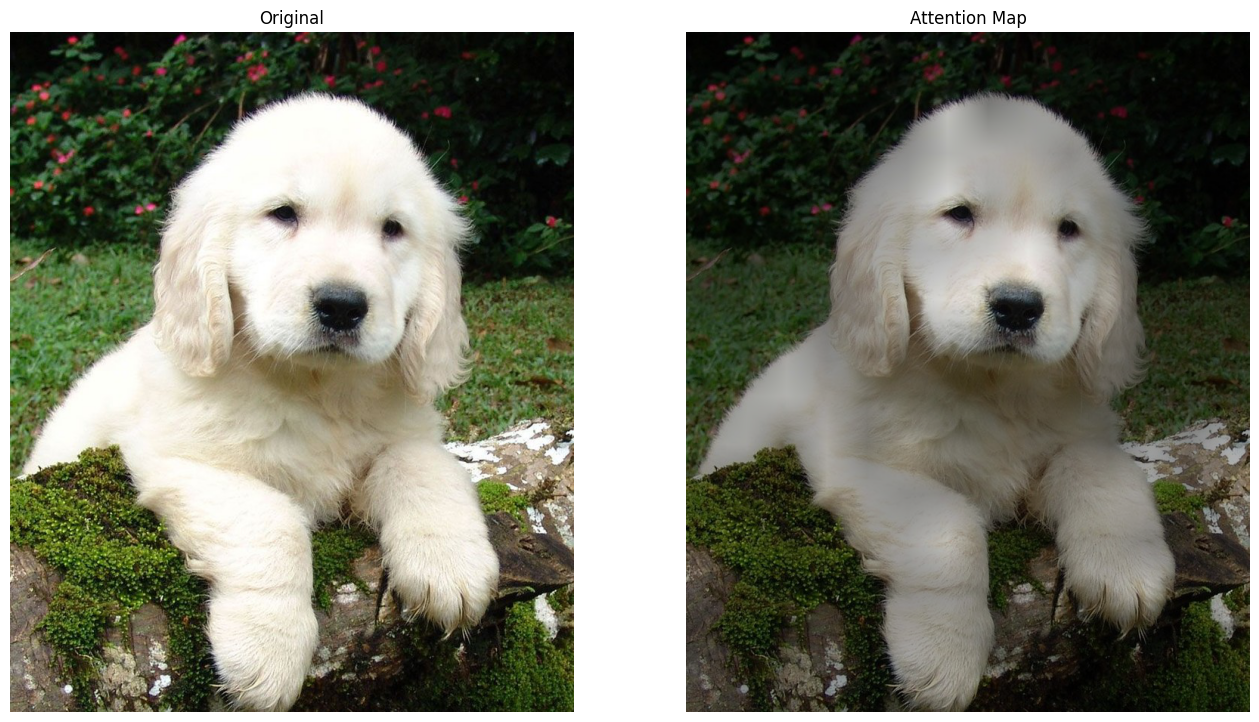

In [33]:
fig, ax = plt.subplots(1,2, figsize=(16,16))

ax[0].set_title('Original')
ax[1].set_title('Attention Map')
ax[0].imshow(im)
ax[1].imshow(result)
ax[0].axis('off')
ax[1].axis('off')

print("Attention Map!\n")

Now using that we can visualize the attention map for every attention head.

In [ ]:
# TODO: Implement the attention map for each attention heads of the transformer.